### Section 1: Overview and descriptive statistics

In [1]:
library(tidyverse)
library(data.table)
library(patchwork)
library(ggcorrplot)
library(ggpubr)

setwd("~/work/mpra-v2")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [ ]:
# Paths and variables

bartenderPath = 'bartender/novaseq/1KG_bartendCombiner_cluster.csv'
oligoMapPath = 'scratch/1KG_STAR_filteredOligoBarcodeMap_combined.txt'
sampleLabels = c("plasmid1","cDNA1","plasmid2","cDNA2","plasmid3","cDNA3")

In [ ]:
# Read in bartender cluster counts and oligo-barcode map

barcodeCounts = fread(bartenderPath, header = T, sep = ',')
oligoMap = fread(oligoMapPath, header = F, sep = "\t")
names(oligoMap) = c("barcode","oligo","n")

In [ ]:
# Merge across samples to form oligo count matrix and write to file

mergedCounts = merge(oligoMap, barcodeCounts, by.x = "barcode", by.y = "Center")
mergedCounts = mergedCounts[,-c(1,3,4,5)]

In [ ]:
# Sum barcodes within each oligo and separate oligo strings into columns

summedCounts = mergedCounts %>% 
                    group_by(oligo) %>% 
                    summarize_all(funs(sum)) %>% 
                    separate(col = "oligo", 
                             into = c("Pool","VarID","geneID","chrom","pos","strand","ref","alt","allele","haploFlag","restrictionFlag","length", "numOtherVars"), 
                             sep = "_")

head(summedCounts)

In [ ]:
# Merge variants within oligo and fix text formatting

summedCountsRef = summedCounts[which(summedCounts$allele == "allele=ref"),]
summedCountsAlt = summedCounts[which(summedCounts$allele != "allele=ref"),]

mergedOligoSums = merge(summedCountsRef, summedCountsAlt, by = c("Pool","VarID","geneID","chrom","pos","strand","ref","alt","haploFlag"))
mergedOligoSums = mergedOligoSums[,c(1:9,14:19,24:29)]

sampleNames = unlist(str_split(sampleLabels, ","))
names(mergedOligoSums)[10:15] = paste0(sampleNames, "_","ref")
names(mergedOligoSums)[16:21] = paste0(sampleNames, "_","alt")
mergedOligoSums[,1:9] = as.data.frame(lapply(mergedOligoSums[,1:9], function(x) {gsub(".*=", "", x, perl = T)}))

In [ ]:
fwrite(mergedOligoSums, '1KG_bartenderOligoSums_novaSeq.txt', 
       quote = F, sep = '\t', row.names = F, col.names =  T)

In [2]:
mergedOligoSums = fread("data/1KG_bartenderOligoSums_novaSeq.txt")

In [3]:
mergedOligoCPM = mergedOligoSums
mergedOligoCPM[,10:21] = sweep(mergedOligoCPM[,10:21],
                                2,
                                colSums(mergedOligoCPM[,10:21])/1000000,
                                `/`)

dna1vdna2 = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = plasmid2_ref), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("Plasmid Replicate 2 (Reference Allele)")
dna1vrna1 = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = cDNA1_ref), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("cDNA Replicate 1(Reference Allele)")
dnaRefAlt = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = plasmid1_alt), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("Plasmid Replicate 1 (Alternative Allele)")
rnaRefAlt = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = cDNA1_ref, y = cDNA1_alt), alpha = 0.1, size = 3) +
                xlab("cDNA Replicate 1 (Reference Allele)") + ylab("cDNA Replicate 1 (Alternative Allele)")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 93 rows containing missing values (geom_point).”
Warning message:
“Removed 138 rows containing missing values (geom_point).”


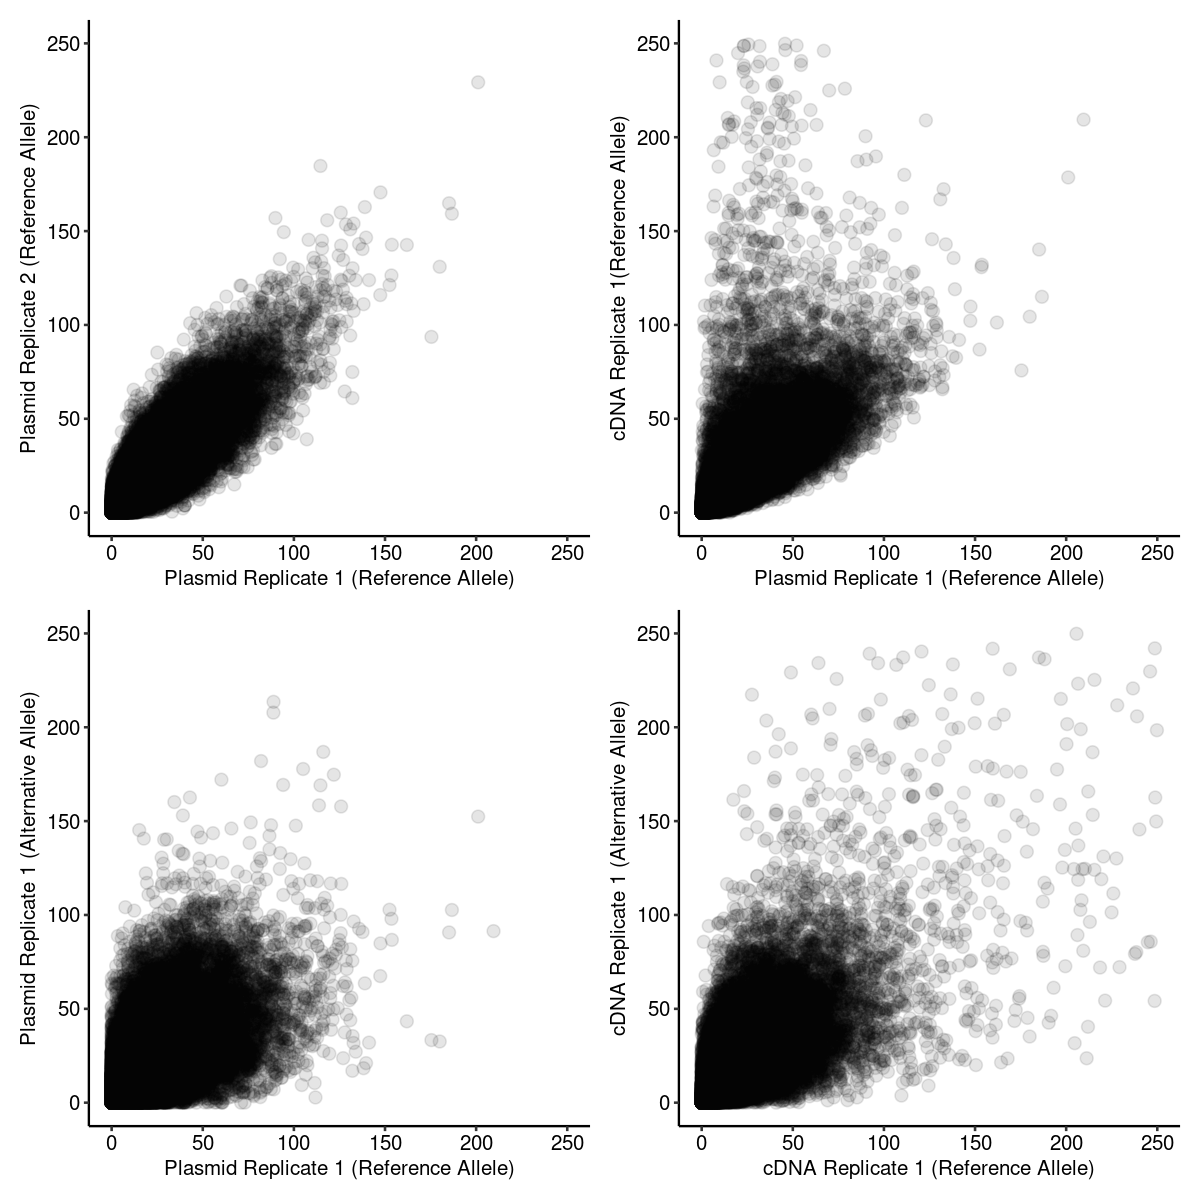

In [4]:
options(repr.plot.width = 10, repr.plot.height = 10)
(dna1vdna2 + dna1vrna1) / (dnaRefAlt + rnaRefAlt) & 
    theme_pubr() & 
    xlim(c(0,250)) & 
    ylim(c(0,250))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



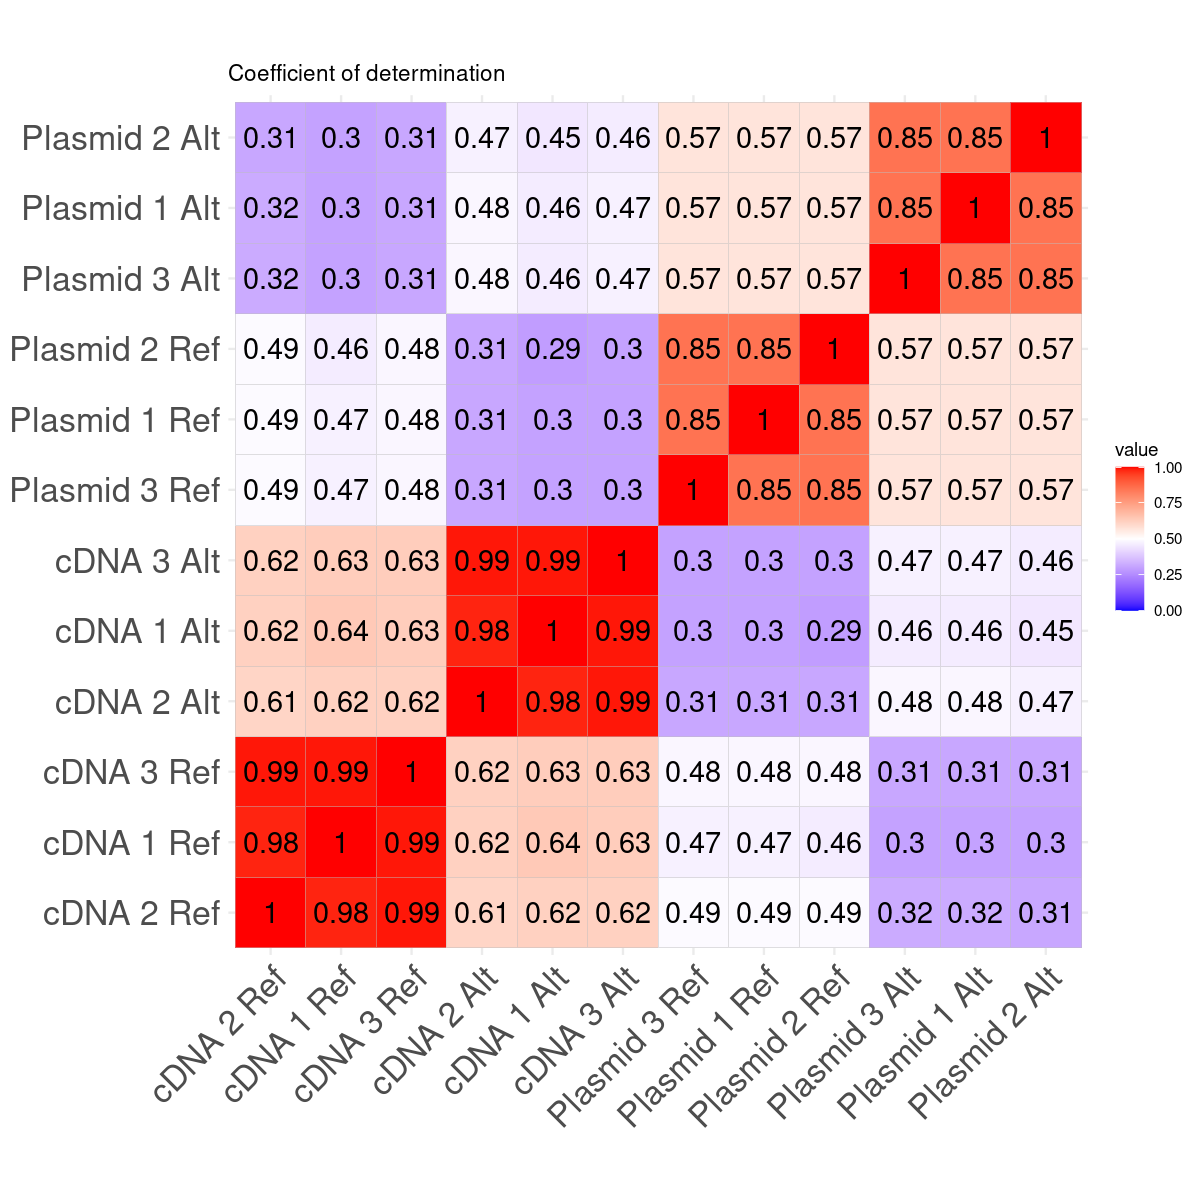

In [8]:
corMat = cor(mergedOligoCPM[,10:21], method = "pearson", use = "pairwise.complete.obs")
samples = c("Plasmid 1 Ref", "cDNA 1 Ref",
            "Plasmid 2 Ref", "cDNA 2 Ref",
            "Plasmid 3 Ref", "cDNA 3 Ref",
            "Plasmid 1 Alt", "cDNA 1 Alt",
            "Plasmid 2 Alt", "cDNA 2 Alt",
            "Plasmid 3 Alt", "cDNA 3 Alt")

colnames(corMat) = samples
rownames(corMat) = samples

ggcorrplot(corMat,
           hc.order = T,
           tl.cex = 20,
           pch.cex = 20,
           lab_size = 6,
           lab = T,
           show.diag = F,
           title = "Coefficient of determination") + scale_fill_gradient2(limit = c(0,1), midpoint = 0.5,low = "blue",mid = "white", high =  "red")

In [6]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.4.0      ggcorrplot_0.1.3  patchwork_1.1.0   data.table_1.13.2
 [5] forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2       purrr_0.3.4      
 [9] readr_1.4.0       tidyr_1.1.2       tibble_3.0.4      ggplot2_3.3.2    
[13] tidyverse_1.3.0  

loaded via a namespace (and not attached):
 [1] httr_1.4.2       jsonlite_1.7.1 